# Evaluate data pre-processing methods

Imblearn package has a number of undersampling and oversampling methods as well as combinations of the two. For the purpose of this study we will investigate:

* Undersampling
    * RandomUnderSampler:  randomly selecting a subset of data for the targeted classes
    
    * ClusterCentroids: subset consists of the centroids of the K-means method
    
    * EditedNearestNeighbours: applies a nearest-neighbors algorithm and removes samples which do not agree “enough” with their neighbourhood.
    
    * TomekLinks: identifies and removes Tomek's links between classes
    
* Oversampling:
    * RandomOverSampler: generate new samples by randomly sampling with replacement the current available samples. 
    
    * SMOTE: Synthetic Minority Oversampling Technique (three variants)
    
    
* Combination:
    * SMOTETOmek - combination of SMOTE and TomekLinks
    
    * SMOTEENN - combination of SMOTE and ENN nearest-neighbors algorithm


In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, 
ClusterCentroids, EditedNearestNeighbours)
from imblearn.base import SamplerMixin
from imblearn.utils import hash_X_y
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# simulate imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit

def simulate_dataset(n_samples=1000, weights=None, n_classes=4,
                   class_sep=0.9, n_clusters=1, random_state=None):
    X, y = make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=random_state)
    return X, y

In [3]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT
# plot the decision function of a classifier given some data
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [4]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT
# plot the sample space after resampling 
# to illustrate the characteristic of an algorithm.
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_sample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8)
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

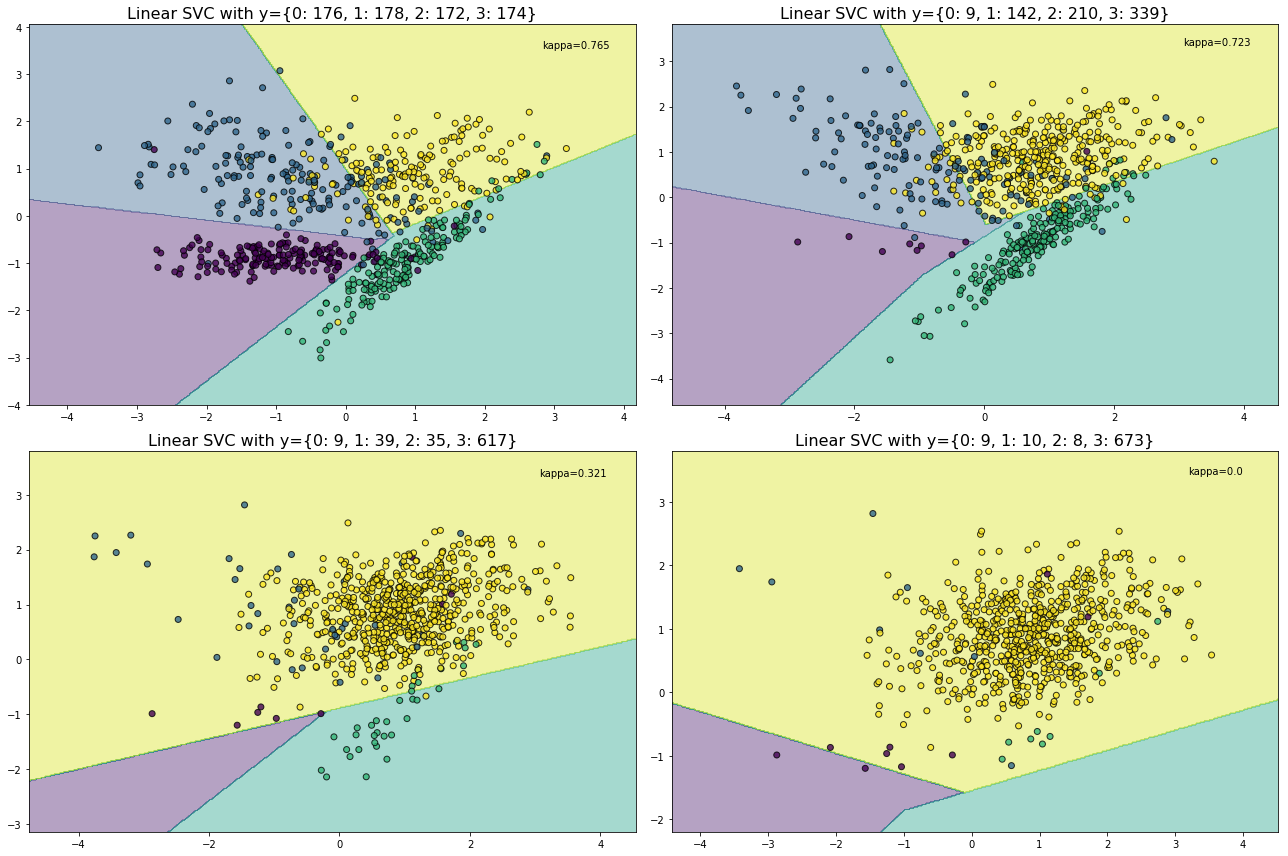

In [5]:
seed = 0
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

ax_arr = (ax1, ax2, ax3, ax4)
weights_arr = ((0.25, 0.25, 0.25, 0.25), (0.01, 0.2, 0.3, 0.49),
               (0.01, 0.05, 0.05, 0.89), (0.01, 0.01, 0.01, 0.97), 
                )
coords = {0:(3.8,3.5),1:(4.1,3.3), 2:(4.1,3.3),3:(4.0,3.4)}
for i, (ax, weights) in enumerate(zip(ax_arr, weights_arr)):
    X, y = simulate_dataset(n_samples=1000, weights=weights, random_state=seed)
# split dataset into training and test sets
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    clf = SVC(kernel="linear",random_state=seed)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_train, y_train, clf, ax)
    ax.set_title('Linear SVC with y={}'.format(dict(Counter(y_train))), fontsize=16)
    c1, c2 = coords[i]
    ax.text(c1, c2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right')
fig.tight_layout()
plt.show()

## Undersampling methods

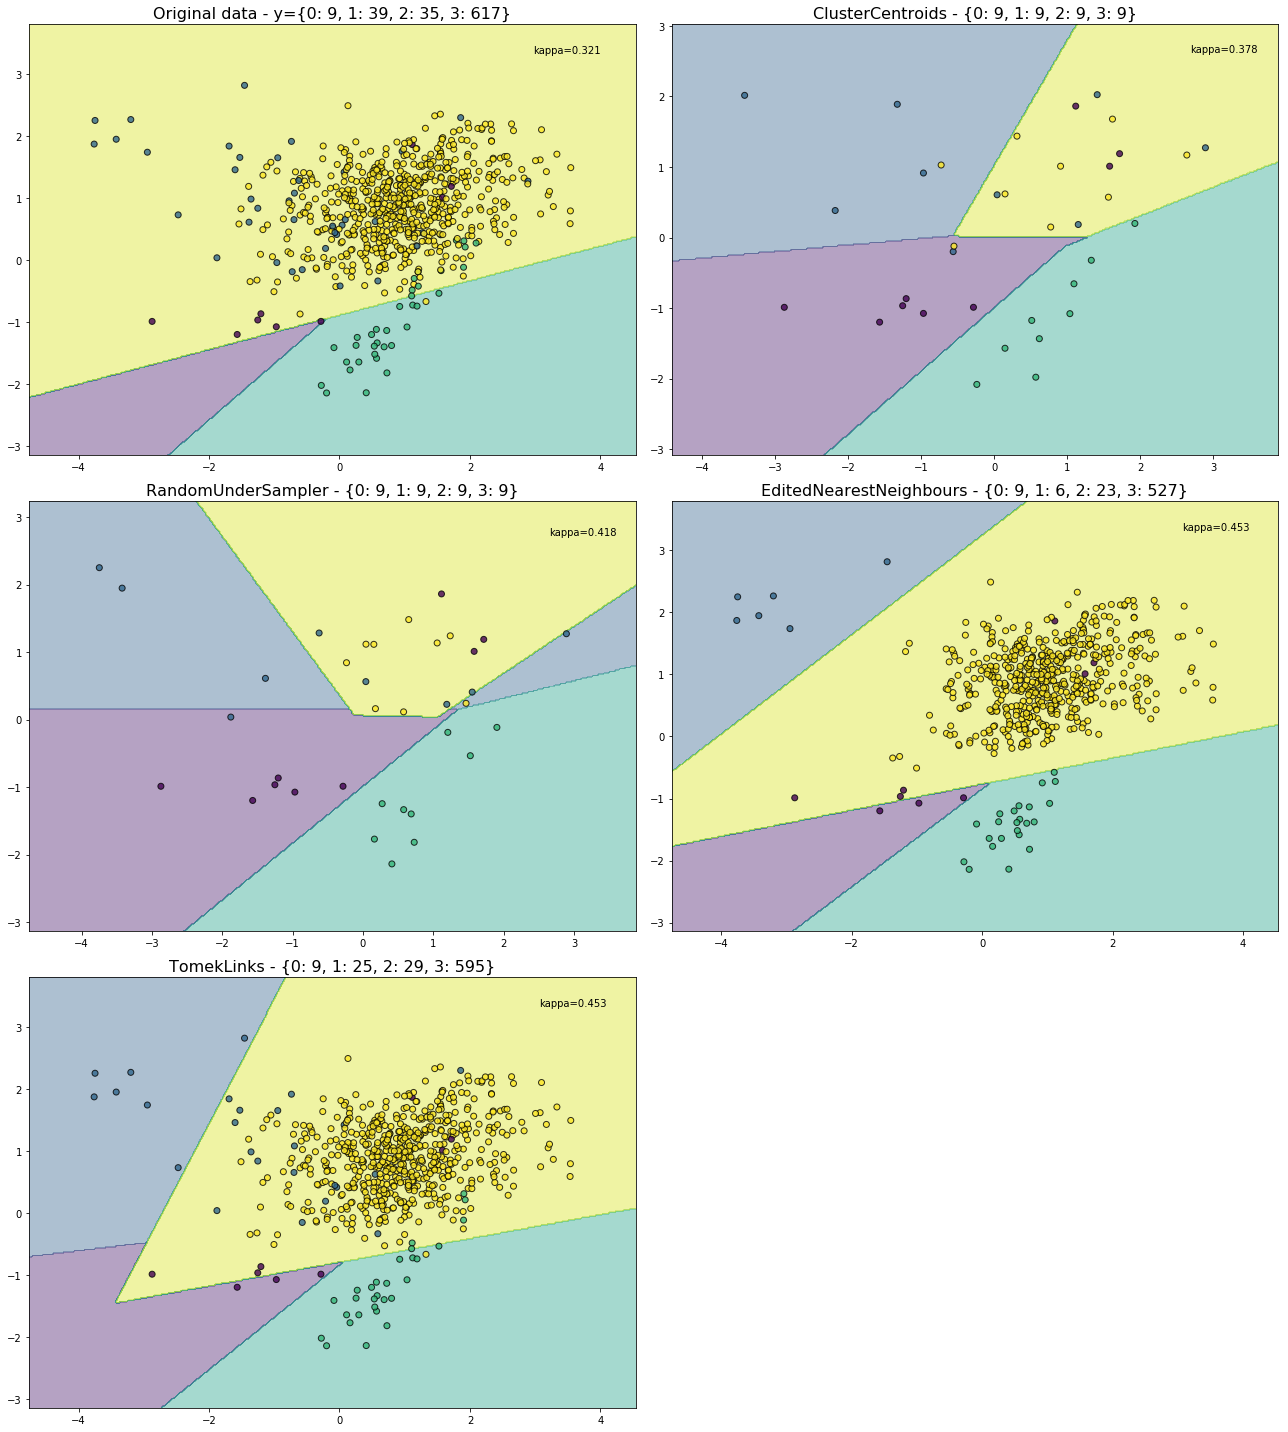

In [6]:
X, y = simulate_dataset(weights=(0.01, 0.05, 0.05, 0.89), random_state=seed)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
fig = plt.figure(figsize=(18, 20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)

clf = SVC(kernel="linear",random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred)
plot_decision_function(X_train, y_train, clf, ax1)
ax1.set_title('Original data - y={}'.format(dict(Counter(y_train))), fontsize=16)
ax1.text(4.0, 3.3, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right')

coords = {0:(3.6,2.6),1:(3.6,2.7), 2:(4.1,3.3),3:(4.1,3.3)}
ax_arr = (ax2, ax3, ax4, ax5)
for i, (ax, sampler) in enumerate(zip(ax_arr, (ClusterCentroids(random_state=seed),
                                               RandomUnderSampler(random_state=seed),
                                               EditedNearestNeighbours(random_state=seed),
                                               TomekLinks(random_state=seed)))):
    clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
    clf.fit(X_train, y_train)
    X_res, y_res = sampler.fit_sample(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('{} - {}'.format(
        sampler.__class__.__name__, dict(Counter(y_res))), fontsize=16)
    c1, c2 = coords[i]
    ax.text(c1, c2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right')
fig.tight_layout()
plt.show()

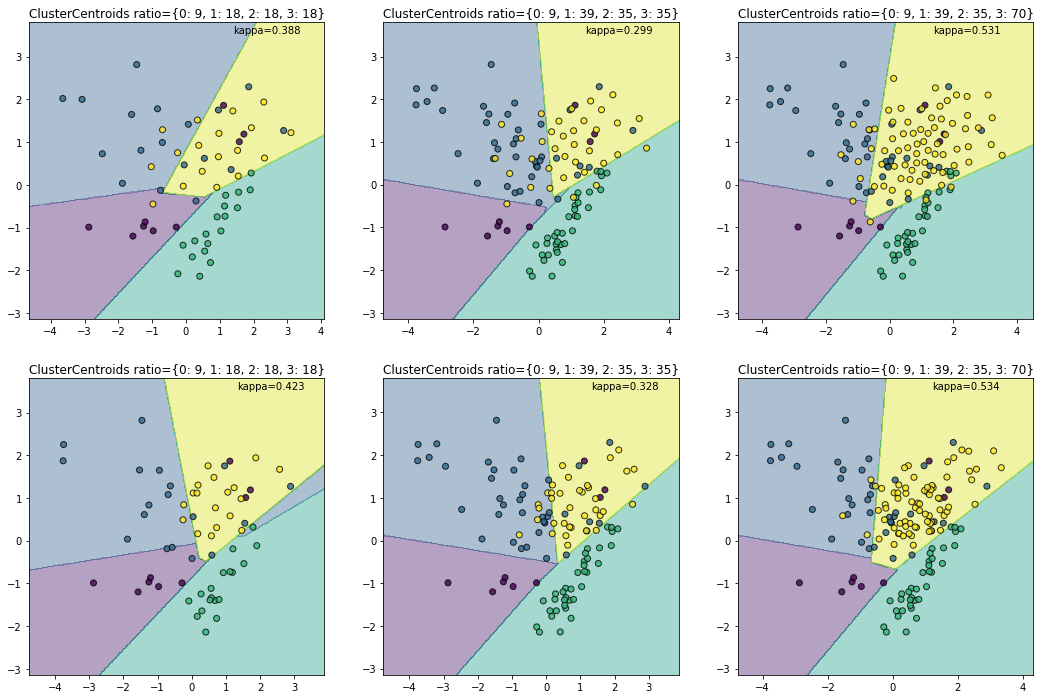

In [7]:
fig, ((ax1, ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(18, 12))

coords = {0:(3.4, 3.5), 1:(3.5, 3.5), 2:(3.5, 3.5)}
ax_arr = (ax1, ax2, ax3)
ratios = [{0:9, 1:18, 2:18, 3:18}, {0:9, 1:39, 2:35, 3:35}, {0:9, 1:39, 2:35, 3:70}]
for n, (ax, ratio) in enumerate(zip(ax_arr, ratios)):
    sampler = ClusterCentroids(random_state=seed, ratio=ratio)
    clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
    X_res, y_res = sampler.fit_sample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('ClusterCentroids ratio={}'.format(ratio))
    c1, c2 = coords[n]
    ax.text(c1, c2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right')
coords = {0:(3.3, 3.5), 1:(3.3, 3.5), 2:(3.3, 3.5)}
ax_arr = (ax4, ax5, ax6)
for n, (ax, ratio) in enumerate(zip(ax_arr, ratios)):
    sampler = RandomUnderSampler(random_state=seed, ratio=ratio)
    clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
    X_res, y_res = sampler.fit_sample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('ClusterCentroids ratio={}'.format(ratio))
    c1, c2 = coords[n]
    ax.text(c1, c2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right')
plt.show()

In [8]:
sampler = TomekLinks(random_state=seed, ratio=ratio)
clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
X_res, y_res = sampler.fit_sample(X_train, y_train)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred)
print(Counter(y_res))
print(kappa)

Counter({3: 595, 2: 29, 1: 25, 0: 7})
0.4534370401513559


## Oversampling methods

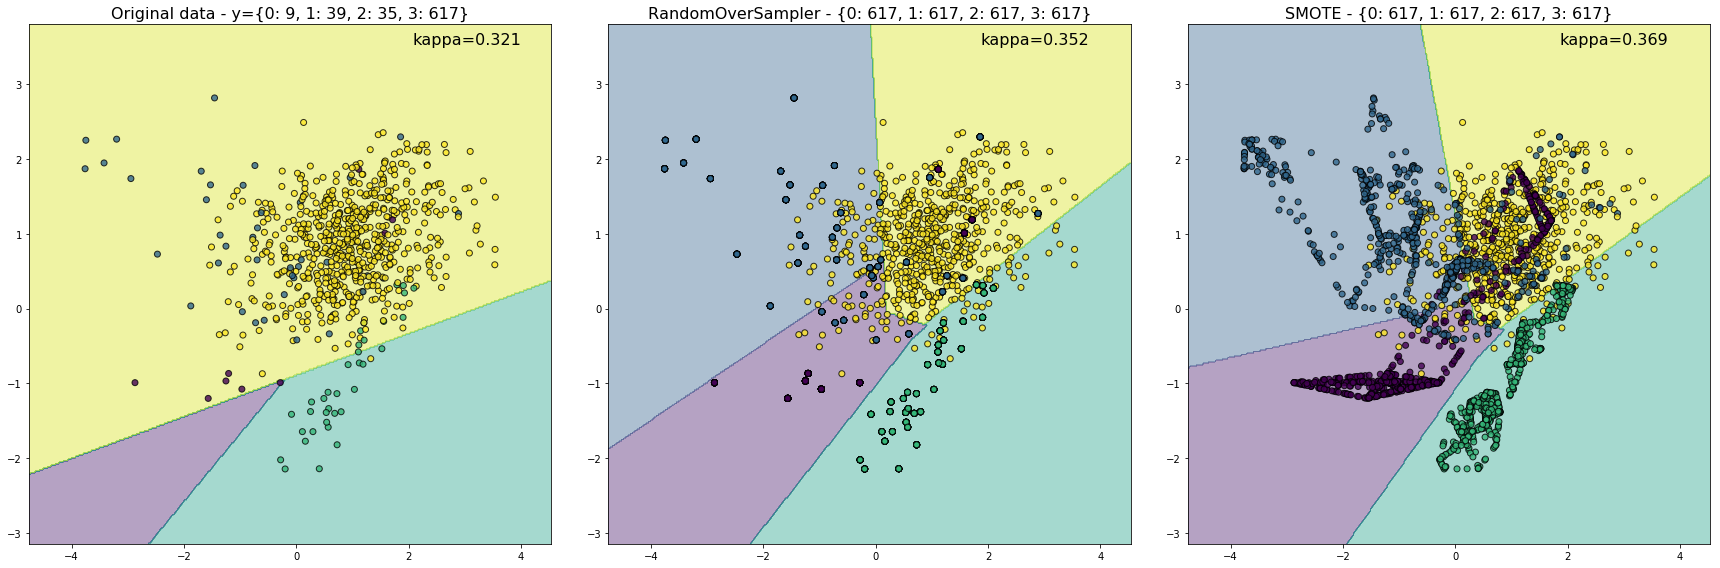

In [9]:
seed=0 
fig = plt.figure(figsize=(24, 8))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

clf = SVC(kernel="linear",random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred)
plot_decision_function(X_train, y_train, clf, ax1)
ax1.set_title('Original data - y={}'.format(dict(Counter(y_train))), fontsize=16)
ax1.text(4, 3.5, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right', fontsize=16)
ax_arr = (ax2, ax3)
coords = {0:(3.8, 3.5), 1:(3.8, 3.5)}
for i, (ax, sampler) in enumerate(zip(ax_arr, (RandomOverSampler(random_state=seed),
                                               SMOTE(random_state=seed)))):
    clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
    clf.fit(X_train, y_train)
    X_res, y_res = sampler.fit_sample(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('{} - {}'.format(
        sampler.__class__.__name__, dict(Counter(y_res))), fontsize=16)
    c1, c2 = coords[i]
    ax.text(c1, c2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right', fontsize=16)

fig.tight_layout()
plt.show()


### Evaluate different variants of SMOTE

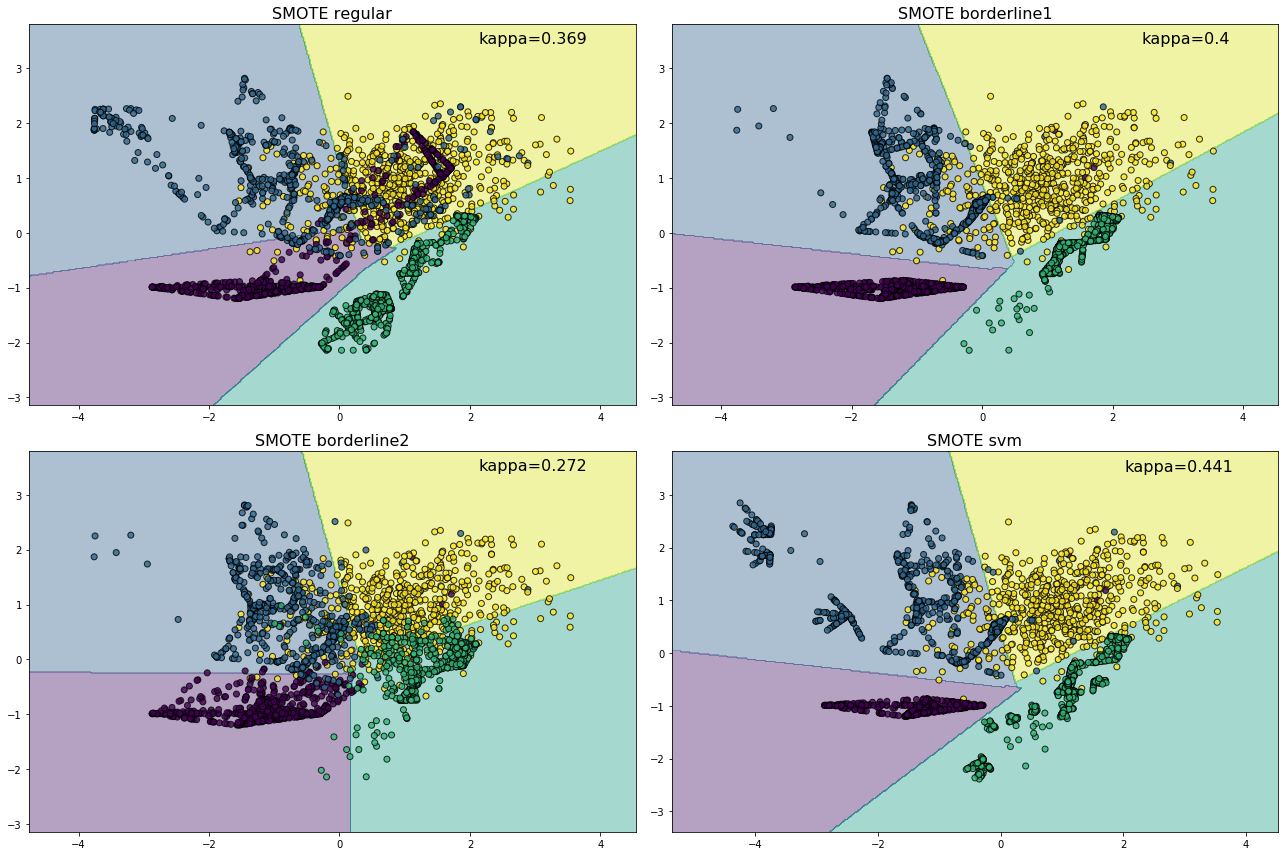

In [10]:
kind = ['regular', 'borderline1', 'borderline2', 'svm']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                                            figsize=(18, 12))
ax_arr = (ax1, ax2, ax3, ax4)
for ax, k in zip(ax_arr, kind):
    smote = SMOTE(kind=k, random_state=seed)
    clf = make_pipeline(smote, SVC(kernel="linear",random_state=seed))
    clf.fit(X_train, y_train)
    X_res, y_res = smote.fit_sample(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('SMOTE {}'.format(k), fontsize=16)
    ax.text(3.8, 3.4, 'kappa={}'.format(round(kappa,3)),
        verticalalignment='bottom', horizontalalignment='right', fontsize=16)

fig.tight_layout()
plt.show()


## Combinations

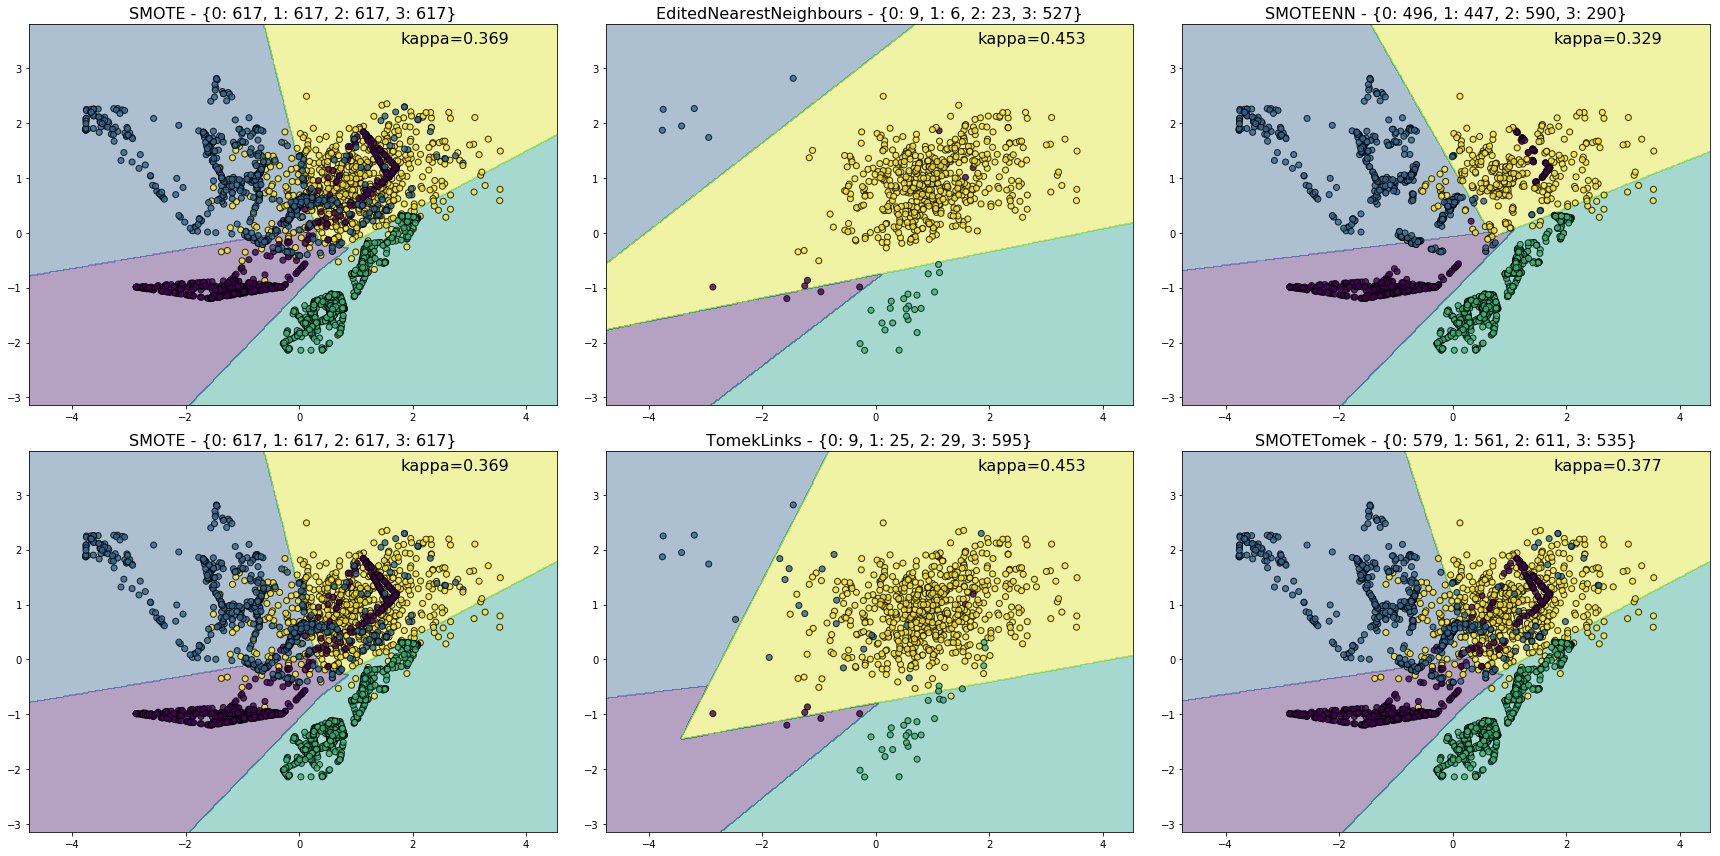

In [11]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,
                                            figsize=(24, 12))

ax_arr = (ax1, ax2, ax3, ax4, ax5, ax6)
for ax, sampler in zip(ax_arr, (SMOTE(random_state=seed),
                                EditedNearestNeighbours(random_state=seed),
                                SMOTEENN(random_state=seed),
                                SMOTE(random_state=seed),
                                TomekLinks(random_state=seed),
                                SMOTETomek(random_state=seed))):
    clf = make_pipeline(sampler, SVC(kernel="linear",random_state=seed))
    X_res, y_res = sampler.fit_sample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)
    plot_decision_function(X_res, y_res, clf, ax)
    ax.set_title('{} - {}'.format(sampler.__class__.__name__, dict(Counter(y_res))),
                fontsize=16)
    ax.text(3.7, 3.4, 'kappa={}'.format(round(kappa,3), fontsize=16),
        verticalalignment='bottom', horizontalalignment='right', fontsize=16)
fig.tight_layout()
plt.show() 